###This code will:

Generate the stress-strain data with noise.
Split the data into training and testing sets.
Train Linear Regression, KNN, and Random Forest models on the training data.
Perform Uncertainty Quantification using bootstrapping for Linear Regression and KNN, and the built-in feature for Random Forest.
Print the Mean Squared Error (MSE) and R² score for each model.
Plot the actual vs. predicted stress-strain data with uncertainty for all three models. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Simulated data generation
np.random.seed(42)
E_true = 210e3  # Young's modulus in MPa (MPa is standard for stress, so strain is unitless)
num_samples = 100

# Generate strain values between 0 and 0.02 (unitless strain)
strain = np.linspace(0, 0.02, num_samples)

# Generate stress using Hooke's law with added noise
stress = E_true * strain + np.random.normal(0, 500, num_samples)  # Stress in MPa

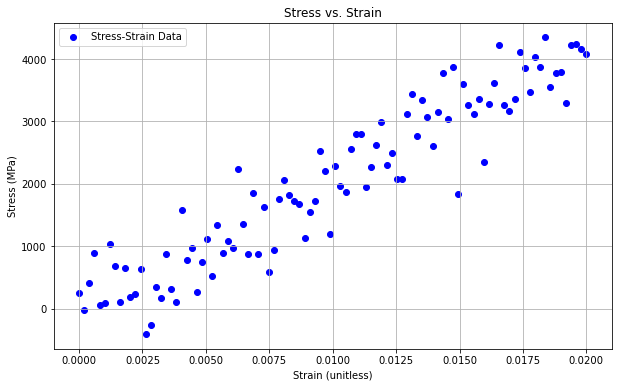

In [2]:
# Plot the generated data as a scatter plot with no lines joining the data points
plt.figure(figsize=(10, 6))
plt.scatter(strain, stress, label='Stress-Strain Data', color='b', marker='o')
plt.xlabel('Strain (unitless)')
plt.ylabel('Stress (MPa)')
plt.title('Stress vs. Strain')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# Split the data into training and testing sets (80% train, 20% test)
strain_train, strain_test, stress_train, stress_test = train_test_split(strain, stress, test_size=0.2, random_state=42)

# Reshape the data for the models
strain_train = strain_train.reshape(-1, 1)
strain_test = strain_test.reshape(-1, 1)

In [4]:
#Train ML models
# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(strain_train, stress_train)
stress_pred_lr = lr_model.predict(strain_test)

# Train a KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(strain_train, stress_train)
stress_pred_knn = knn_model.predict(strain_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(strain_train, stress_train)
stress_pred_rf = rf_model.predict(strain_test)

In [5]:
# Calculate accuracy metrics for all models
mse_lr = mean_squared_error(stress_test, stress_pred_lr)
r2_lr = r2_score(stress_test, stress_pred_lr)

mse_knn = mean_squared_error(stress_test, stress_pred_knn)
r2_knn = r2_score(stress_test, stress_pred_knn)

mse_rf = mean_squared_error(stress_test, stress_pred_rf)
r2_rf = r2_score(stress_test, stress_pred_rf)

print(f'Linear Regression - MSE: {mse_lr:.2f}, R^2: {r2_lr:.2f}')
print(f'KNN - MSE: {mse_knn:.2f}, R^2: {r2_knn:.2f}')
print(f'Random Forest - MSE: {mse_rf:.2f}, R^2: {r2_rf:.2f}')

Linear Regression - MSE: 155510.56, R^2: 0.91
KNN - MSE: 198407.28, R^2: 0.88
Random Forest - MSE: 233909.23, R^2: 0.86


#### Bootstrap prediction is a statistical technique used to estimate the accuracy of a predictive model by resampling the data with replacement. This method helps to assess the variability and robustness of the model’s predictions.

In [6]:
# Uncertainty Quantification using bootstrapping for Linear Regression and KNN
def bootstrap_predictions(model, X_train, y_train, X_test, n_bootstrap=100):
    predictions = []
    for _ in range(n_bootstrap):
        # Resample the training data with replacement
        indices = np.random.choice(len(X_train), len(X_train), replace=True)
        X_resample = X_train[indices]
        y_resample = y_train[indices]
        
        # Train the model on the resampled data
        model.fit(X_resample, y_resample)
        
        # Predict on the test set
        predictions.append(model.predict(X_test))
    
    return np.array(predictions)

# Bootstrap predictions for Linear Regression and KNN
bootstrap_preds_lr = bootstrap_predictions(lr_model, strain_train, stress_train, strain_test)
bootstrap_preds_knn = bootstrap_predictions(knn_model, strain_train, stress_train, strain_test)

In [7]:
# Calculate mean and standard deviation of predictions for Linear Regression and KNN
mean_preds_lr = bootstrap_preds_lr.mean(axis=0)
std_preds_lr = bootstrap_preds_lr.std(axis=0)

mean_preds_knn = bootstrap_preds_knn.mean(axis=0)
std_preds_knn = bootstrap_preds_knn.std(axis=0)

In [8]:
# Uncertainty Quantification for Random Forest using built-in feature of the model
rf_model.fit(strain_train, stress_train)
rf_preds_all_trees = np.array([tree.predict(strain_test) for tree in rf_model.estimators_])
mean_preds_rf = rf_preds_all_trees.mean(axis=0)
std_preds_rf = rf_preds_all_trees.std(axis=0)

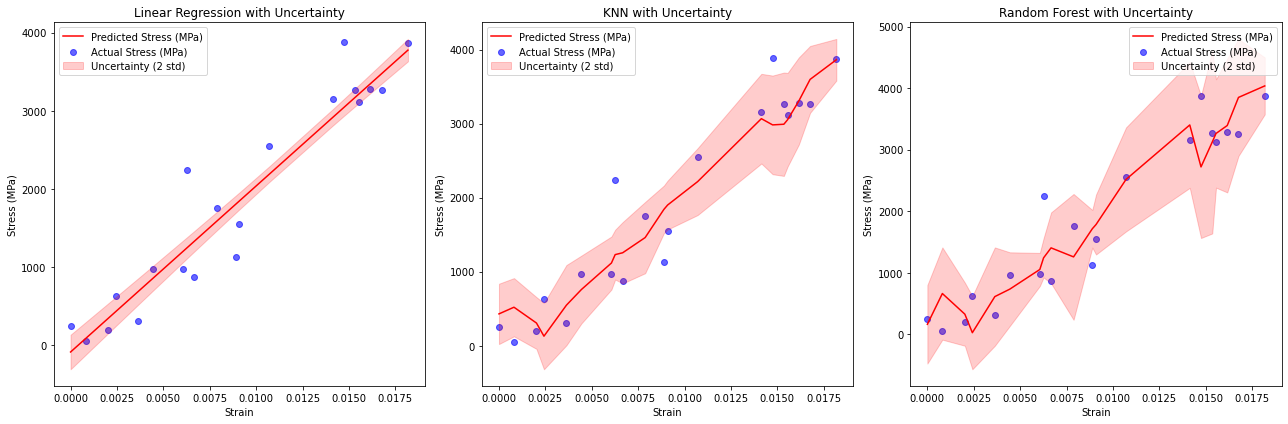

In [9]:
# Sort the values before plotting
sorted_indices_lr = np.argsort(strain_test.flatten())
sorted_indices_knn = np.argsort(strain_test.flatten())
sorted_indices_rf = np.argsort(strain_test.flatten())

strain_test_sorted_lr = strain_test.flatten()[sorted_indices_lr]
mean_preds_lr_sorted = mean_preds_lr[sorted_indices_lr]
std_preds_lr_sorted = std_preds_lr[sorted_indices_lr]

strain_test_sorted_knn = strain_test.flatten()[sorted_indices_knn]
mean_preds_knn_sorted = mean_preds_knn[sorted_indices_knn]
std_preds_knn_sorted = std_preds_knn[sorted_indices_knn]

strain_test_sorted_rf = strain_test.flatten()[sorted_indices_rf]
mean_preds_rf_sorted = mean_preds_rf[sorted_indices_rf]
std_preds_rf_sorted = std_preds_rf[sorted_indices_rf]

# Plot actual vs predicted data with uncertainty for all models
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(strain_test_sorted_lr, stress_test[sorted_indices_lr], label='Actual Stress (MPa)', color='blue', alpha=0.6)
plt.plot(strain_test_sorted_lr, mean_preds_lr_sorted, label='Predicted Stress (MPa)', color='red')
plt.fill_between(strain_test_sorted_lr.flatten(), mean_preds_lr_sorted - 2 * std_preds_lr_sorted,
                 mean_preds_lr_sorted + 2 * std_preds_lr_sorted,
                 color='red', alpha=0.2, label='Uncertainty (2 std)')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Linear Regression with Uncertainty')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(strain_test_sorted_knn, stress_test[sorted_indices_knn], label='Actual Stress (MPa)', color='blue', alpha=0.6)
plt.plot(strain_test_sorted_knn, mean_preds_knn_sorted, label='Predicted Stress (MPa)', color='red')
plt.fill_between(strain_test_sorted_knn.flatten(), mean_preds_knn_sorted - 2 * std_preds_knn_sorted,
                 mean_preds_knn_sorted + 2 * std_preds_knn_sorted,
                 color='red', alpha=0.2, label='Uncertainty (2 std)')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('KNN with Uncertainty')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(strain_test_sorted_rf, stress_test[sorted_indices_rf], label='Actual Stress (MPa)', color='blue', alpha=0.6)
plt.plot(strain_test_sorted_rf, mean_preds_rf_sorted, label='Predicted Stress (MPa)', color='red')
plt.fill_between(strain_test_sorted_rf.flatten(), mean_preds_rf_sorted - 2 * std_preds_rf_sorted,
                 mean_preds_rf_sorted + 2 * std_preds_rf_sorted,
                 color='red', alpha=0.2, label='Uncertainty (2 std)')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Random Forest with Uncertainty')
plt.legend()

plt.tight_layout()
plt.show()


Linear Regression - MSE: 237507.60, R^2: 0.86
KNN - MSE: 273731.08, R^2: 0.84
Random Forest - MSE: 340273.35, R^2: 0.80


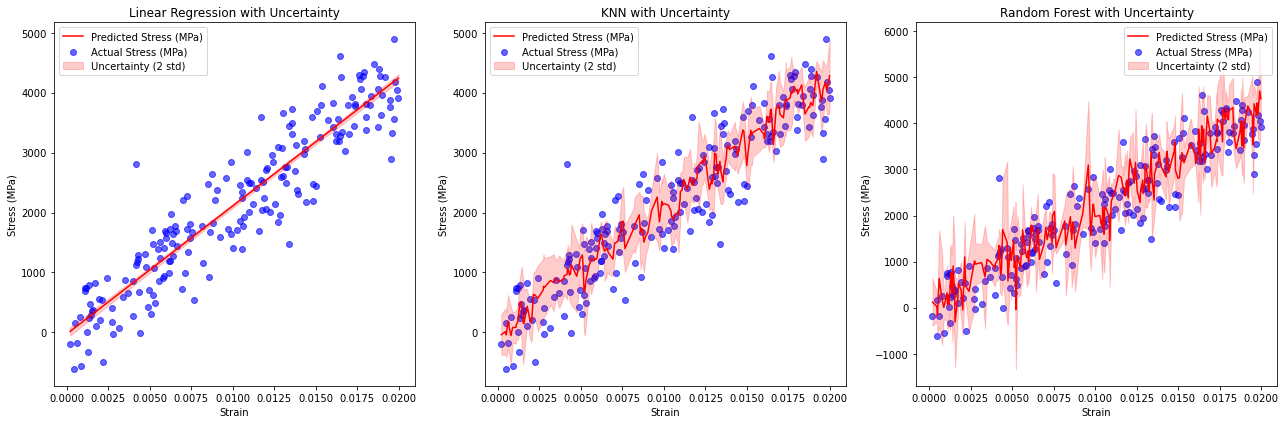

In [10]:
#Increase number of samples
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Simulated data generation
np.random.seed(42)
E_true = 210e3  # Young's modulus in MPa (MPa is standard for stress, so strain is unitless)
num_samples = 1000

# Generate strain values between 0 and 0.02 (unitless strain)
strain = np.linspace(0, 0.02, num_samples)

# Generate stress using Hooke's law with added noise
stress = E_true * strain + np.random.normal(0, 500, num_samples)  # Stress in MPa

# Split the data into training and testing sets (80% train, 20% test)
strain_train, strain_test, stress_train, stress_test = train_test_split(strain, stress, test_size=0.2, random_state=42)

# Reshape the data for the models
strain_train = strain_train.reshape(-1, 1)
strain_test = strain_test.reshape(-1, 1)

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(strain_train, stress_train)
stress_pred_lr = lr_model.predict(strain_test)

# Train a KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(strain_train, stress_train)
stress_pred_knn = knn_model.predict(strain_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(strain_train, stress_train)
stress_pred_rf = rf_model.predict(strain_test)

# Calculate accuracy metrics for all models
mse_lr = mean_squared_error(stress_test, stress_pred_lr)
r2_lr = r2_score(stress_test, stress_pred_lr)

mse_knn = mean_squared_error(stress_test, stress_pred_knn)
r2_knn = r2_score(stress_test, stress_pred_knn)

mse_rf = mean_squared_error(stress_test, stress_pred_rf)
r2_rf = r2_score(stress_test, stress_pred_rf)

print(f'Linear Regression - MSE: {mse_lr:.2f}, R^2: {r2_lr:.2f}')
print(f'KNN - MSE: {mse_knn:.2f}, R^2: {r2_knn:.2f}')
print(f'Random Forest - MSE: {mse_rf:.2f}, R^2: {r2_rf:.2f}')

# Uncertainty Quantification using bootstrapping for Linear Regression and KNN
def bootstrap_predictions(model, X_train, y_train, X_test, n_bootstrap=100):
    predictions = []
    for _ in range(n_bootstrap):
        # Resample the training data with replacement
        indices = np.random.choice(len(X_train), len(X_train), replace=True)
        X_resample = X_train[indices]
        y_resample = y_train[indices]
        
        # Train the model on the resampled data
        model.fit(X_resample, y_resample)
        
        # Predict on the test set
        predictions.append(model.predict(X_test))
    
    return np.array(predictions)

# Bootstrap predictions for Linear Regression and KNN
bootstrap_preds_lr = bootstrap_predictions(lr_model, strain_train, stress_train, strain_test)
bootstrap_preds_knn = bootstrap_predictions(knn_model, strain_train, stress_train, strain_test)

# Calculate mean and standard deviation of predictions for Linear Regression and KNN
mean_preds_lr = bootstrap_preds_lr.mean(axis=0)
std_preds_lr = bootstrap_preds_lr.std(axis=0)

mean_preds_knn = bootstrap_preds_knn.mean(axis=0)
std_preds_knn = bootstrap_preds_knn.std(axis=0)

# Uncertainty Quantification for Random Forest using built-in feature of the model
rf_model.fit(strain_train, stress_train)
rf_preds_all_trees = np.array([tree.predict(strain_test) for tree in rf_model.estimators_])
mean_preds_rf = rf_preds_all_trees.mean(axis=0)
std_preds_rf = rf_preds_all_trees.std(axis=0)

# Sort the values before plotting
sorted_indices_lr = np.argsort(strain_test.flatten())
sorted_indices_knn = np.argsort(strain_test.flatten())
sorted_indices_rf = np.argsort(strain_test.flatten())

strain_test_sorted_lr = strain_test.flatten()[sorted_indices_lr]
mean_preds_lr_sorted = mean_preds_lr[sorted_indices_lr]
std_preds_lr_sorted = std_preds_lr[sorted_indices_lr]

strain_test_sorted_knn = strain_test.flatten()[sorted_indices_knn]
mean_preds_knn_sorted = mean_preds_knn[sorted_indices_knn]
std_preds_knn_sorted = std_preds_knn[sorted_indices_knn]

strain_test_sorted_rf = strain_test.flatten()[sorted_indices_rf]
mean_preds_rf_sorted = mean_preds_rf[sorted_indices_rf]
std_preds_rf_sorted = std_preds_rf[sorted_indices_rf]

# Plot actual vs predicted data with uncertainty for all models
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(strain_test_sorted_lr, stress_test[sorted_indices_lr], label='Actual Stress (MPa)', color='blue', alpha=0.6)
plt.plot(strain_test_sorted_lr, mean_preds_lr_sorted, label='Predicted Stress (MPa)', color='red')
plt.fill_between(strain_test_sorted_lr.flatten(), mean_preds_lr_sorted - 2 * std_preds_lr_sorted,
                 mean_preds_lr_sorted + 2 * std_preds_lr_sorted,
                 color='red', alpha=0.2, label='Uncertainty (2 std)')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Linear Regression with Uncertainty')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(strain_test_sorted_knn, stress_test[sorted_indices_knn], label='Actual Stress (MPa)', color='blue', alpha=0.6)
plt.plot(strain_test_sorted_knn, mean_preds_knn_sorted, label='Predicted Stress (MPa)', color='red')
plt.fill_between(strain_test_sorted_knn.flatten(), mean_preds_knn_sorted - 2 * std_preds_knn_sorted,
                 mean_preds_knn_sorted + 2 * std_preds_knn_sorted,
                 color='red', alpha=0.2, label='Uncertainty (2 std)')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('KNN with Uncertainty')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(strain_test_sorted_rf, stress_test[sorted_indices_rf], label='Actual Stress (MPa)', color='blue', alpha=0.6)
plt.plot(strain_test_sorted_rf, mean_preds_rf_sorted, label='Predicted Stress (MPa)', color='red')
plt.fill_between(strain_test_sorted_rf.flatten(), mean_preds_rf_sorted - 2 * std_preds_rf_sorted,
                 mean_preds_rf_sorted + 2 * std_preds_rf_sorted,
                 color='red', alpha=0.2, label='Uncertainty (2 std)')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Random Forest with Uncertainty')
plt.legend()

plt.tight_layout()
plt.show()
